In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential,Model
from keras.layers import Conv1D,Input,Softmax,concatenate,InputLayer,Flatten,Dense,Activation
import tensorflow as tf

In [2]:
df = pd.read_csv('D:\\Career\\GradProj\\Datasets\\dataset4.csv')

In [ ]:
df.drop(['Unnamed: 0','window number'],axis = 1,inplace=True)

In [5]:
df.drop(['7 x', '8 x', '9 x', '10 x', '11 x', '12 x', '7 y', '8 y', '9 y',
        '10 y', '11 y', '12 y', '7 z', '8 z', '9 z', '10 z', '11 z', '12 z'],axis = 1,inplace=True)

In [9]:
from keras import Sequential
from tcn import TCN

In [10]:
# Adding callbacks

# class CustomSaver(tf.keras.callbacks.Callback):
#     def on_epoch_end(self,model , epoch, logs={}):
#         if epoch == 5:  # or save after some epoch, each k-th epoch etc.
#             self.model.save(f"D:\\Career\\GradProj\\Model_no_feat\\All_models\\{epoch}.hd5")

# saver = CustomSaver()
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.6,
    patience=4,
    )

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='D:\\Career\\GradProj\\Model_no_feat\\Best_model_1.hdf5', verbose=0, save_best_only=True)

csv_logger = tf.keras.callbacks.CSVLogger("D:\\Career\\GradProj\\Model_no_feat\\model_history_log.csv", append=True)

In [11]:
df_windows = np.array(df.iloc[:171000]).reshape(-1,75,42)

In [18]:
from keras.layers import UpSampling1D,AveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

In [36]:
class TCNAE:
    """
    A class used to represent the Temporal Convolutional Autoencoder (TCN-AE).

    ...

    Attributes
    ----------
    model : xxtypexx
        The TCN-AE model.

    Methods
    -------
    build_model(verbose = 1)
        Builds the model
    """
    
    model = None
    
    def __init__(self,
                 ts_dimension = 1,
                 dilations = (1, 2, 4, 8, 16),
                 nb_filters = 42,
                 kernel_size = 20,
                 nb_stacks = 1,
                 padding = 'same',
                 dropout_rate = 0.00,
                 filters_conv1d = 8,
                 activation_conv1d = 'linear',
                 latent_sample_rate = 42,
                 pooler = AveragePooling1D,
                 lr = 0.001,
                 conv_kernel_init = 'glorot_normal',
                 loss = 'logcosh',
                 use_early_stopping = False,
                 error_window_length = 128,
                 verbose = 1
                ):
        """
        Parameters
        ----------
        ts_dimension : int
            The dimension of the time series (default is 1)
        dilations : tuple
            The dilation rates used in the TCN-AE model (default is (1, 2, 4, 8, 16))
        nb_filters : int
            The number of filters used in the dilated convolutional layers. All dilated conv. layers use the same number of filters (default is 20)
        """
        
        self.ts_dimension = ts_dimension
        self.dilations = dilations
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.nb_stacks = nb_stacks
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.filters_conv1d = filters_conv1d
        self.activation_conv1d = activation_conv1d
        self.latent_sample_rate = latent_sample_rate
        self.pooler = pooler
        self.lr = lr
        self.conv_kernel_init = conv_kernel_init
        self.loss = loss
        self.use_early_stopping = use_early_stopping
        self.error_window_length = error_window_length
        
        # build the model
        self.build_model(verbose = verbose)
        
    
    def build_model(self, verbose = 1):
        """Builds the TCN-AE model.

        If the argument `verbose` isn't passed in, the default verbosity level is used.

        Parameters
        ----------
        verbose : str, optional
            The verbosity level (default is 1)
            
        Returns
        -------
        KerasXYZType
        Todo

        Raises
        ------
        NotImplementedError
            If ...
        """
        
        tf.keras.backend.clear_session()
        sampling_factor = self.latent_sample_rate
        i = Input((75, 42))

        # Put signal through TCN. Output-shape: (batch,sequence length, nb_filters)
        tcn_enc = TCN(nb_filters=self.nb_filters, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=self.dilations, 
                      padding=self.padding, use_skip_connections=True, dropout_rate=self.dropout_rate, return_sequences=True,
                      kernel_initializer=self.conv_kernel_init, name='tcn-enc')(i)

        # Now, adjust the number of channels...
        enc_flat = Conv1D(filters=self.filters_conv1d, kernel_size=1, activation=self.activation_conv1d, padding=self.padding)(tcn_enc)

        ## Do some average (max) pooling to get a compressed representation of the time series (e.g. a sequence of length 8)
        enc_pooled = self.pooler(pool_size=sampling_factor, strides=None, padding='valid', data_format='channels_last')(enc_flat)
        
        # If you want, maybe put the pooled values through a non-linear Activation
        enc_out = Activation("linear")(enc_pooled)

        # Now we should have a short sequence, which we will upsample again and then try to reconstruct the original series
        dec_upsample = UpSampling1D(size=sampling_factor)(enc_out)

        dec_reconstructed = TCN(nb_filters=self.nb_filters, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=self.dilations, 
                                padding=self.padding, use_skip_connections=True, dropout_rate=self.dropout_rate, return_sequences=True,
                                kernel_initializer=self.conv_kernel_init, name='tcn-dec')(dec_upsample)

        # Put the filter-outputs through a dense layer finally, to get the reconstructed signal
        o = Dense(self.ts_dimension, activation='linear')(dec_reconstructed)

        model = Model(inputs=[i], outputs=[o])

        adam = Adam(learning_rate=self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True)
        model.compile(loss=self.loss, optimizer=adam, metrics=[self.loss])
        if verbose > 1:
            model.summary()
        self.model = model
    
    def fit(self, train_X, train_Y, batch_size=32, epochs=40, verbose = 1):
        my_callbacks = None
        if self.use_early_stopping:
            my_callbacks = [EarlyStopping(monitor='val_loss', patience=2, min_delta=1e-4, restore_best_weights=True),rlr,checkpointer,csv_logger]

        keras_verbose = 0
        if verbose > 0:
            print("> Starting the Training...")
            keras_verbose = 2
        start = time.time()
        history = self.model.fit(train_X, train_Y, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_split=0.001, 
                            shuffle=True,
                            callbacks=my_callbacks,
                            verbose=keras_verbose)
        if verbose > 0:
            print("> Training Time :", round(time.time() - start), "seconds.")
    
    # def predict(self, test_X):
    #     X_rec =  self.model.predict(test_X)
        
    #     # do some padding in the end, since not necessarily the whole time series is reconstructed
    #     X_rec = np.pad(X_rec, ((0,0),(0, test_X.shape[1] - X_rec.shape[1] ), (0,0)), 'constant') 
    #     E_rec = (X_rec - test_X).squeeze()
    #     Err = utilities.slide_window(pandas.DataFrame(E_rec), self.error_window_length, verbose = 0)
    #     Err = Err.reshape(-1, Err.shape[-1]*Err.shape[-2])
    #     sel = np.random.choice(range(Err.shape[0]),int(Err.shape[0]*0.98))
    #     mu = np.mean(Err[sel], axis=0)
    #     cov = np.cov(Err[sel], rowvar = False)
    #     sq_mahalanobis = utilities.mahalanobis_distance(X=Err[:], cov=cov, mu=mu)
    #     # moving average over mahalanobis distance. Only slightly smooths the signal
    #     anomaly_score = np.convolve(sq_mahalanobis, np.ones((50,))/50, mode='same')
    #     anomaly_score = np.sqrt(anomaly_score)
    #     return anomaly_score

In [49]:
from keras.layers import Activation

In [54]:
def TCNAE():
        ts_dimension = 1,
        dilations = (1, 2, 4, 8, 16),
        nb_filters = 42,
        kernel_size = 20,
        nb_stacks = 1,
        padding = 'same',
        dropout_rate = 0.00,
        filters_conv1d = 8,
        activation_conv1d = 'relu',
        latent_sample_rate = 42,
        pooler = AveragePooling1D,
        lr = 0.001,
        conv_kernel_init = 'glorot_normal',
        loss = 'logcosh',
        use_early_stopping = False,
        error_window_length = 128,
        verbose = 1
        sampling_factor = latent_sample_rate
        i = Input((75, 42))

        # Put signal through TCN. Output-shape: (batch,sequence length, nb_filters)
        tcn_enc = TCN(nb_filters=42, kernel_size=5, nb_stacks=1, dilations=(1, 2, 4, 8, 16), 
                padding='same', use_skip_connections=True, dropout_rate=.2, return_sequences=True,
                kernel_initializer='glorot_normal',input_shape=[75, 42])(i)

        # Now, adjust the number of channels...
        enc_flat = Conv1D(filters=filters_conv1d, kernel_size=1, activation=activation_conv1d, padding=padding)(tcn_enc)

        ## Do some average (max) pooling to get a compressed representation of the time series (e.g. a sequence of length 8)
        enc_pooled = pooler(pool_size=sampling_factor, strides=None, padding='valid', data_format='channels_last')(enc_flat)
        
        # If you want, maybe put the pooled values through a non-linear Activation
        enc_out = Activation("relu")(enc_pooled)

        # Now we should have a short sequence, which we will upsample again and then try to reconstruct the original series
        dec_upsample = UpSampling1D(size=sampling_factor)(enc_out)

        dec_reconstructed = TCN(nb_filters=nb_filters, kernel_size=kernel_size, nb_stacks=nb_stacks, dilations=dilations, 
                                padding=padding, use_skip_connections=True, dropout_rate=dropout_rate, return_sequences=True,
                                kernel_initializer=conv_kernel_init, name='tcn-dec')(dec_upsample)

        # Put the filter-outputs through a dense layer finally, to get the reconstructed signal
        o = Dense(ts_dimension, activation='relu')(dec_reconstructed)

        model = Model(inputs=[i], outputs=[o])

        adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True)
        model.compile(loss=loss, optimizer=adam, metrics=[loss])
        return model

In [55]:
# model = Sequential(
#             TCN(nb_filters=42, kernel_size=5, nb_stacks=1, dilations=(1, 2, 4, 8, 16), 
#             padding='same', use_skip_connections=True, dropout_rate=.2, return_sequences=True,
#             kernel_initializer='glorot_normal',input_shape=[75, 42]))
model = TCNAE()

TypeError: Could not interpret activation function identifier: ('relu',)

In [21]:
from keras.layers import Dropout,MaxPooling1D,UpSampling1D,Reshape
from sklearn.model_selection import train_test_split

In [158]:
# def cnn2(trainX, trainy, testX, testy):
#     verbose, epochs, batch_size = 0, 10, 32
#     n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
#     # head 1
#     inputs1 = Input(shape=(n_timesteps,n_features))
#     conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
#     drop1 = Dropout(0.5)(conv1)
#     pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)
#     # head 2
#     inputs2 = Input(shape=(n_timesteps,n_features))
#     conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
#     drop2 = Dropout(0.5)(conv2)
#     pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)
#     # head 3
#     inputs3 = Input(shape=(n_timesteps,n_features))
#     conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
#     drop3 = Dropout(0.5)(conv3)
#     pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)
#     # merge
#     merged = concatenate([flat1, flat2, flat3])
#     # interpretation
#     flat = Flatten()(merged)
#     dense1 = Dense(100, activation='relu')(flat)

#     funnel = Dense(60, activation='relu')(dense1)
#     d2 = Reshape((15,4))(funnel)
#     conv4 = Conv1D(filters=30, kernel_size=5, activation='relu')(d2)
#     conv5 = Conv1D(filters=60, kernel_size=5, activation='relu')(conv4)
#     # d4 = UpSampling1D(2)(conv5)
#     # conv6 = Conv1D(filters=64, kernel_size=5, activation='relu')(d4)
#     # d4 = UpSampling1D(2)(conv6)
#     # decoded = Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d4)
#     d4 = UpSampling1D(2)(conv5)
#     d5 = UpSampling1D(2)(d4)
#     # d6 = Reshape((75,60))(d5)
#     conv6 = Conv1D(filters=60, kernel_size=5, activation='relu')(d5)
#     model = Model(inputs=[inputs1, inputs2, inputs3], outputs=conv6)
#     return model

In [105]:
# X = df_windows.copy()

In [110]:
# df_windows.shape,X.shape

((2280, 75, 60), (2280, 75, 60))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_windows, df_windows, test_size=0.20, random_state=42)

In [159]:
# model2 = cnn2(X_train,y_train,X_test,y_test)

In [160]:
# model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 75, 60)]     0           []                               
                                                                                                  
 input_47 (InputLayer)          [(None, 75, 60)]     0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 75, 60)]     0           []                               
                                                                                                  
 conv1d_68 (Conv1D)             (None, 73, 64)       11584       ['input_46[0][0]']               
                                                                                            

In [106]:
# np.apply_along_axis(np.random.shuffle,1,X) 

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [120]:
#Is shuffled?
df_windows[0][0][20]==-0.0070042377642942

True

In [107]:
# X.shape

(2280, 75, 60)

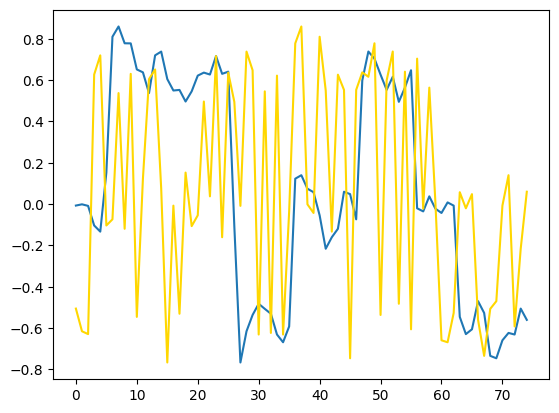

In [113]:
# plt.plot(df_windows[0,:,20])

# plt.plot(X[0,:,20],color = 'gold')

In [28]:
df_windows[0][:][21].shape

(60,)

In [29]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#                         loss=tf.keras.losses.MeanSquaredError(), 
#                         metrics=['accuracy'])

AttributeError: 'TCNAE' object has no attribute 'compile'

In [38]:
# training
model.fit(  X_train, y_train,
            epochs=100,
            # callbacks=[rlr,checkpointer,csv_logger],
            batch_size=32)

> Starting the Training...
Epoch 1/100


ValueError: in user code:

    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1949, in log_cosh
        return backend.mean(_logcosh(y_pred - y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 42 and 75 for '{{node log_cosh/sub}} = Sub[T=DT_FLOAT](model/dense/BiasAdd, IteratorGetNext:1)' with input shapes: [?,42,1], [?,75,42].


In [39]:
X_train.shape

(1824, 75, 42)

In [40]:
model.summary

AttributeError: 'TCNAE' object has no attribute 'summary'